In [1]:
import numpy as np
import cv2

def mutual_information(image1, image2, bins=256):
    # Calculate the histogram of the images
    hist_2d, _, _ = np.histogram2d(image1.ravel(), image2.ravel(), bins=bins)

    # Calculate the joint probability distribution
    pxy = hist_2d / float(np.sum(hist_2d))
    px = np.sum(pxy, axis=1) # Marginal for x over y
    py = np.sum(pxy, axis=0) # Marginal for y over x

    # Calculate the mutual information
    px_py = px[:, None] * py[None, :]
    nzs = pxy > 0 # Non-zero joint probabilities
    mi = np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

    return mi

MI: 0.9320585898759294


(<AxesSubplot: title={'center': 'floated'}>,
 Text(0.5, 1.0, 'floated'))

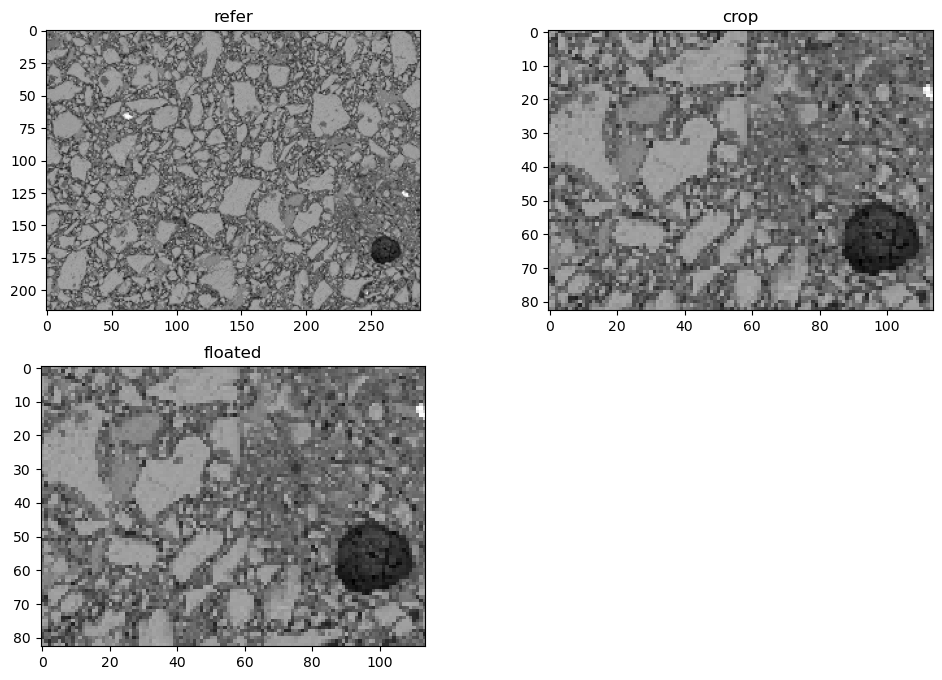

In [16]:
import cv2
import matplotlib.pyplot as plt

def crop_rotate(image, center, size, angle):
    """
    Crop and rotate a region from an image.

    :param image: Source image
    :param center: Tuple (x, y) - the center of the region to crop
    :param size: Tuple (width, height) - the size of the region to crop
    :param angle: Rotation angle in degrees
    :return: Cropped and rotated image region
    """

    # Get rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Perform rotation
    rotated = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))

    # Calculate the coordinates of the top-left corner of the cropped region
    x = int(center[0] - size[0] / 2)
    y = int(center[1] - size[1] / 2)

    # Crop the region
    # 防止出现超出数组范围的情况

    # Define row and column ranges
    start_row, end_row = y, y + size[0]  # Example row range
    start_col, end_col = x, x + size[1]  # Example column range

    # Define the fill value for out-of-bounds indices
    fill_value = 0.0

    # 对超出区域的处理
    cropped = [[rotated[i][j] if i < len(rotated) and j < len(rotated[i]) else fill_value 
          for j in range(start_col, end_col)] 
         for i in range(start_row, end_row)]
    # cropped = rotated[y:y + size[1], x:x + size[0]]

    return cropped

# Load the images
refered_img = cv2.imread('images/3d-6.tif', cv2.IMREAD_GRAYSCALE)
floated_img = cv2.imread('images/3d-6-2-crop.tif', cv2.IMREAD_GRAYSCALE)


width, height = refered_img.shape

# Specify center, size, and angle
center = (205, 165)  # Example center position (x, y)
size = (83, 114)      # Example size (width, height)
angle = 0           # Example rotation angle in degrees

# Crop and rotate
cropped_image = crop_rotate(refered_img, center, size, angle)

mi = mutual_information(floated_img, np.array(cropped_image))

print(f"MI: {mi}")

# Display the images
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1), plt.imshow(refered_img, cmap='gray'), plt.title('refer')
plt.subplot(2, 2, 2), plt.imshow(cropped_image, cmap='gray'), plt.title('crop')
plt.subplot(2, 2, 3), plt.imshow(floated_img, cmap='gray'), plt.title('floated')

# Question: 
# 1. 使用的坐标系是哪个？需要确定裁剪区域在图像的哪一位置。图像是先进行了旋转，再进行了移动，先不管旋转后的超出区域直接丢弃的处理。
# 2. 裁剪超过对应区域怎么办？用0填充